# Comparison between Signature based ensemble classifiers

In this notebook, we explore the classification results of signature/log signature features on 114 datasets of the [UCR repository](https://arxiv.org/abs/1810.07758). We compare the performance of two signature-based ensemble classifiers.

### Background
The [signature method in machine learning](https://arxiv.org/abs/1603.03788) has the following basic workflow:
```
Data --> Path --> Signature Features --> Classification 
```
The focus of this notebook is the first step of turning raw data (in this case, univariate time series)
into paths for which we can compute signatures, which we refer to as embedding the data as a path.
We consider the following embeddings for (unindexed) univariate time series:
- lead-lag
- time-indexed
- time-joined
- partial sum + lead-lag
- partial sum + time-indexed
- partial sum + time-joined

These embeddings are the most common and tend to be quite universally applicable. Their implementation can be found in the `classifiers.py` module under
this git repository.

Usually, it is a priori not clear which one of these embeddings works best for the data at hand.
Often one has to test each of the embeddings separately and pick the one that yields the best
results on the training set.
A natural way to work around this is to create some kind of an ensemble classifier that includes all
of these embeddings.


## Approach

We study two such possible ensembles in the current notebook:

- Feature union of all embeddings
- Voting-based ensemble classifier

### Feature union (`Sig-Concat`)
The approach we take for this ensemble is as follows:

1. Compute log signature features for each of the six path embeddings; this yields 6 arrays
   of length `n`
2. Concatenate the 6 arrays, which is of length `6*n`
3. Perform logistic regression on the resulting feature array

The construction of such an ensemble is implemented in `create_concatenator`
function in `classifiers.py`.
The reason we use log signatures is to minimalize the total number of features.
For each dataset in the UCR repo, we repeat classification for
all the signature levels `[2,3, ..., 10]`.

### Voting-based ensemble classifier (`Sig-COTE`)

This approach is the so-called [Flat-COTE voting ensemble](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7069254).
The idea is as follows:
1. Construct a separate classifier for each of the 6 path embeddings using logistic regression
2. For each classifier, perform `k`-fold cross-validation on the training set
3. Set the voting weights for each classifier to be the mean of the cross-validation scores
4. Train each classifier on the entire training set
5. On a testing instance, each classifier makes a separate prediction. The final
   predicted result is the class label which has the highest vote score. The vote score
   for each label is obtained by a weighted sum of the voting weights
   and the estimated prediction probability.

This ensemble is implemented by the `create_vote_clf` function in `classifiers.py`.
In contrast to the feature union, each classifier uses signature features rather than
log signature features.

In our experiment, `k` is set to 3.
Again, each classification is repeated for all the signature levels `[2,3, ..., 10]` on
every dataset.


## Example on single dataset

Before we analyze the results on all 114 datasets, let's run both ensembles
on a single dataset: ECG200.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from classifiers import create_vote_clf, create_concatenator
from tasks import load_data

In [2]:
X_train, y_train, X_test, y_test = load_data('ECG200')

This classification problem has two class labels, `-1` and `+1`.
The dataset consists of 100 testing and training samples.
Let's plot a few individual time series.

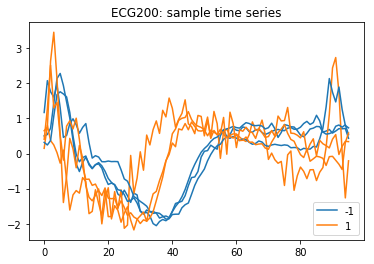

In [3]:
c = {'-1':'tab:blue', '1': 'tab:orange'}
for i, ts in enumerate(X_train[0:6]):
    plt.plot(ts, color=c[y_train[i]])
plt.legend(y_train[0:2])
_ = plt.title("ECG200: sample time series")

Now create two ensemble classifiers for level 6 signature:

In [4]:
logit = LogisticRegression(solver='liblinear', random_state=42)
concat_clf = create_concatenator(logit, level=6, sig_type='logsig')
cote_clf = create_vote_clf(logit, level=6)

and fit them to the training data:

In [5]:
concat_clf.fit(X_train, y_train)
_ = cote_clf.fit(X_train, y_train)

Both classifiers happen to achieve the same score on the testing set:

In [6]:
print(concat_clf.score(X_test, y_test))
print(cote_clf.score(X_test, y_test))

0.82
0.82


## Result analysis all UCR datasets

The results for 114 datasets have been computed and stored in `results/ucr` folder
in the Github repo, we simply need to load them in. These results
have been computed using the scripts `RunVotingEnsemble` and `RunFeatureUnion`
in `tasks.py`. The compute time for all 114 datasets was about 12 hours and 36 hours
for `Sig-Concat` and `Sig-COTE` respectively.

In [7]:
from tasks import load_results

cote, _ = load_results('sig_flatcote_2_3_4_5_6_7_8_9_10.pkl')
ccat, _ = load_results('logsig_concat_2_3_4_5_6_7_8_9_10.pkl')
scores = pd.concat([cote.Score, ccat.Score], axis=1)
scores.columns = ["Sig-COTE", "Sig-Concat"]

In [8]:
scores.head(15)

Sig-COTE  Sig-Concat
ACSF1 2   0.480000    0.460000
      3   0.560000    0.540000
      4   0.540000    0.550000
      5   0.560000    0.580000
      6   0.610000    0.560000
      7   0.610000    0.580000
      8   0.610000    0.580000
      9   0.630000    0.570000
      10  0.650000    0.570000
Adiac 2   0.168798    0.230179
      3   0.250639    0.312020
      4   0.345269    0.388747
      5   0.409207    0.424552
      6   0.465473    0.432225
      7   0.488491    0.445013

We see that each dataset has the classification scores for the signature levels 2 to 10.

### 1. Which signature truncation level works best?

We first look at how the different truncation levels perform.
For this, we simply take the argmax over the truncation levels for each dataset.

In [9]:
top_levels = pd.concat([
    scores.unstack()['Sig-COTE'].idxmax(axis=1),
    scores.unstack()['Sig-Concat'].idxmax(axis=1),
], axis=1)
top_levels.columns = scores.columns
top_levels.head()

,Sig-COTE,Sig-Concat
ACSF1,10.0,5
Adiac,10.0,10
ArrowHead,9.0,7
BME,6.0,4
Beef,10.0,9


Using this, we can plot a histogram:

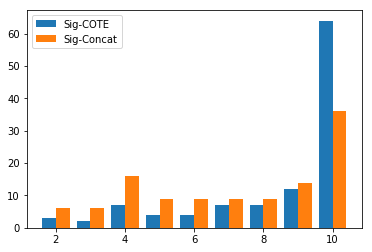

In [10]:
bins=np.arange(1,11)+0.5
plt.hist(top_levels.T, bins=bins, stacked=False)
plt.legend(top_levels.columns)

We see that for both classifiers, the highest score is usually achieved at the highest truncation level.
This makes intuitive sense as signature features of lower truncation levels are strict subsets
of higher truncation levels. For instance, this means that the classifier using level 10 signature
will have every feature the classifier using level 9 signature has, and more.
Theoretically, this would imply that a level 10 classifier should perform better than
a level 9 classifier, since it has more information to work with.
However, in practice, this is not always the case due to overfitting,
as we see in the above graph.

### 2. Comparison between the two ensembles

Right now we have 9 different scores for each dataset.
Having a single score for each dataset will make it easier to do comparison.
For this, we take the **score at the highest signature truncation level (10)**.

In [11]:
compare = scores.xs(10, level=1)
compare.head()

,Sig-COTE,Sig-Concat
ACSF1,0.650000,0.570000
Adiac,0.544757,0.506394
ArrowHead,0.737143,0.685714
BME,0.960000,0.953333
Beef,0.800000,0.733333


A brief summary is given by:

In [12]:
compare.describe()

,Sig-COTE,Sig-Concat
count,110.000000,114.000000
mean,0.790411,0.738871
std,0.164583,0.193088
min,0.176688,0.091346
25%,0.697436,0.638918
50%,0.806944,0.769167
75%,0.927535,0.893455
max,1.000000,1.000000


We see that the COTE voting ensemble has **higher scores** than the feature union
ensemble. To visualize this, we can plot a scatter graph:

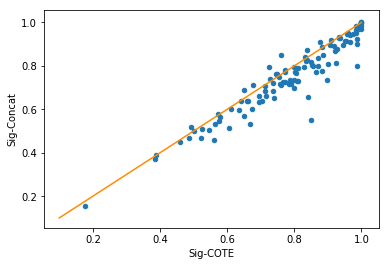

In [13]:
ax = compare.plot.scatter(x='Sig-COTE', y='Sig-Concat')
ax.plot([0.1,1],[0.1,1], c='darkorange') # add diagonal

Each point in this figure represents the classification scores of a single dataset.
That is, if we have a point `(x, y)` in the figure, then `x` is the classification score `Sig-COTE` for that dataset while `y` is the classification score of `Sig-Concat` for that dataset.

Therefore, points that appear below the diagonal correspond to datasets on which `Sig-COTE` performs better; and vice versa.

We see that most points appear below the diagonal, which seems to imply that the **Sig-COTE voting ensemble** performs better.

### 3. Comparison with Benchmarks

Next, we briefly compare these results with benchmark results of several
state-of-the-art time series classification algorithms provided by the
UCR repository.

First, we download the benchmark results from www.timeseriesclassification.com.

In [14]:
def get_benchmarks(url='http://www.timeseriesclassification.com/singleTrainTest.csv'):
    df = pd.read_csv(url)
    df = df.set_index('Unnamed: 0', drop=True)
    df.index.name = 'Dataset'
    # Fix a few mismatches between dataset names
    df = df.rename(index={
        'CinCECGtorso': 'CinCECGTorso',
        'StarlightCurves': 'StarLightCurves'
    })
    return df

bm = get_benchmarks()

In [15]:
bm.head()

,NB,C45,SVML,SVMQ,BN,RandF,RotF,MLP,Euclidean_1NN,DTW_R1_1NN,...,BOSS,TSF,TSBF,LPS,ACF,PS,EE,CID_DTW,Flat-COTE,HIVE-COTE
Dataset,,,,,,,,,,,,,,,,,,,,,
Adiac,0.562660,0.542199,0.442455,0.762148,0.501279,0.636829,0.774936,0.736573,0.611253,0.603581,...,0.764706,0.731458,0.769821,0.769821,0.664962,0.751918,0.664962,0.624041,0.790281,0.810742
ArrowHead,0.542857,0.605714,0.731429,0.742857,0.571429,0.714286,0.737143,0.708571,0.800000,0.702857,...,0.834286,0.725714,0.754286,0.782857,0.645714,0.474286,0.811429,0.828571,0.811429,0.862857
Beef,0.666667,0.533333,0.900000,0.933333,0.600000,0.733333,0.866667,0.600000,0.666667,0.633333,...,0.800000,0.766667,0.566667,0.600000,0.733333,0.733333,0.633333,0.633333,0.866667,0.933333
BeetleFly,0.750000,0.900000,0.800000,0.850000,0.850000,0.800000,0.900000,0.800000,0.750000,0.700000,...,0.900000,0.750000,0.800000,0.800000,0.650000,0.850000,0.750000,0.750000,0.800000,0.950000
BirdChicken,0.550000,0.800000,0.650000,0.800000,0.600000,0.750000,0.850000,0.600000,0.550000,0.750000,...,0.950000,0.800000,0.900000,1.000000,0.850000,0.950000,0.800000,0.750000,0.900000,0.850000


We see that the benchmarks contains results for 37 different algorithms.
Let's join these with our results:

In [16]:
bm_compare = pd.concat([bm, compare], axis=1, sort=True).dropna(thresh=3) # drop row if less than 3 non-NA values
bm_compare.describe()

,NB,C45,SVML,SVMQ,BN,RandF,RotF,MLP,Euclidean_1NN,DTW_R1_1NN,...,TSBF,LPS,ACF,PS,EE,CID_DTW,Flat-COTE,HIVE-COTE,Sig-COTE,Sig-Concat
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.650699,0.632901,0.693826,0.734762,0.656455,0.741928,0.775699,0.727980,0.708859,0.740381,...,0.778068,0.786785,0.711063,0.722506,0.792355,0.766322,0.838125,0.847140,0.778554,0.745725
std,0.180029,0.179795,0.198949,0.187435,0.202312,0.155331,0.162594,0.190121,0.175490,0.168606,...,0.161054,0.158830,0.159819,0.174161,0.156309,0.161144,0.140762,0.139583,0.158787,0.161309
min,0.136603,0.065401,0.093882,0.097046,0.112869,0.146624,0.129747,0.097046,0.109177,0.228376,...,0.185000,0.236814,0.230485,0.219937,0.304852,0.220992,0.349156,0.382384,0.176688,0.154008
25%,0.534568,0.533333,0.543860,0.609375,0.549333,0.654321,0.688525,0.597403,0.600000,0.642667,...,0.705263,0.712000,0.616667,0.597199,0.703827,0.674667,0.758515,0.771739,0.694872,0.653846
50%,0.651429,0.625899,0.712230,0.760976,0.664000,0.748201,0.802927,0.766667,0.733333,0.753846,...,0.783333,0.800000,0.712230,0.738333,0.810667,0.780220,0.868852,0.862857,0.800000,0.750000
75%,0.797990,0.757246,0.866667,0.875556,0.831159,0.865979,0.905344,0.894444,0.852222,0.864631,...,0.883382,0.908316,0.820000,0.869416,0.915200,0.881475,0.953945,0.962927,0.898537,0.872852
max,0.960000,0.981992,1.000000,1.000000,0.980952,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The benchmarks only contain results for 85 out of 128 datasets.
This is a subset of our results on 114 datasets.

Let's look at how often each algorithm performs the best on the datasets
to obtain a rough ranking between the algorithms.

In [17]:
bm_compare.idxmax(axis=1).value_counts()

HIVE-COTE      20
ST             10
SAXVSM          6
BOSS            6
Flat-COTE       5
EE              3
DTW_R1_1NN      3
SVMQ            3
SVML            3
MLP             3
Sig-COTE        3
RotF            3
RandF           2
FS              2
MSM_1NN         2
LS              2
TWE_1NN         1
DD_DTW          1
WDTW_1NN        1
ACF             1
LPS             1
WDDTW_1NN       1
NB              1
Sig-Concat      1
DDTW_Rn_1NN     1
dtype: int64

We see that the benchmark contains two other COTE voting ensembles, [Flat-COTE](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7069254)
and [HIVE-COTE](https://dl.acm.org/citation.cfm?id=3182382).
Flat-COTE uses the same COTE voting ensemble we used for Sig-COTE,
and consists of 30+ different base classifiers (many of which are in the benchmarks),
while Sig-COTE is only
based on the 6 different path embeddings listed above.

By comparing Flat-COTE against our Sig-COTE, we see that most of the times
Flat-COTE performs better.

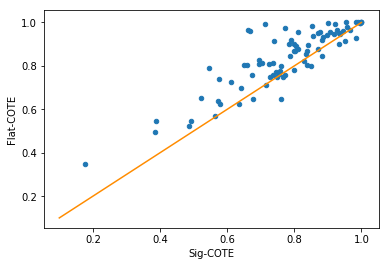

In [18]:
ax = bm_compare.plot.scatter(x='Sig-COTE', y='Flat-COTE')
ax.plot([0.1,1],[0.1,1], c='darkorange') # add diagonal